## Imports

In [1]:
import pandas as pd
import numpy as np
import json
import re
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
root_dir = os.path.abspath(os.curdir)
base_dir = os.path.dirname(root_dir)+"/Data/"
#Create directory to save models
mod_dir = os.path.dirname(root_dir)+"/Models/"
os.makedirs(mod_dir, exist_ok=True)
figs_dir = os.path.dirname(root_dir)+"/Figures/"
os.makedirs(figs_dir, exist_ok=True)
training_dataset = base_dir+'trainingDataset-toxicComments.csv'
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, classification_report
import tensorflow as tf
import transformers
import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer 
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

## Load Dataset
Train / Validation / Test = 7 / 1 / 2

In [2]:
df = pd.read_csv(training_dataset)
myLabels = df[['highly_toxic','slightly_toxic','non_toxic']]
df['category'] = myLabels.idxmax(axis=1)
#Doing some adjustments
a=df['comment_text']
df['label']=df['category'].map({'non_toxic':0, 'slightly_toxic':1,'highly_toxic':2})
b = df['label']
ddf= pd.concat([a,b], axis=1)
ddf

,comment_text,label
0,I mean... have you been to Paris? It's an awes...,0
1,Its cuz i just want it so dam much. I reach fo...,0
2,I used to work at this deli when I was a junio...,0
3,Yeah and I was saying how dumb that is. Its li...,0
4,My friend told me this story about how he wank...,0
...,...,...
10078,Why do you need to mention it though??? why???...,1
10079,The mind rape was all about teaching him to be...,1
10080,Blowjobs are for after the proposal NOT during...,1
10081,"This movie really, really took me by surprise....",1


In [3]:
# Grouping data by label
ddf = ddf.sample(frac=1,random_state=13)
ddf.groupby('label').count()

X_train_, X_test, y_train_, y_test = train_test_split(
    ddf.index.values,
    ddf.label.values,
    test_size=0.10,
    random_state=13,
    stratify=ddf.label.values,    
)

X_train, X_val, y_train, y_val = train_test_split(
    ddf.loc[X_train_].index.values,
    ddf.loc[X_train_].label.values,
    test_size=0.10,
    random_state=13,
    stratify=ddf.loc[X_train_].label.values,  
)

ddf['data_type'] = ['not_set']*ddf.shape[0]
ddf.loc[X_train, 'data_type'] = 'train'
ddf.loc[X_val, 'data_type'] = 'val'
ddf.loc[X_test, 'data_type'] = 'test'

df_train = ddf.loc[ddf["data_type"]=="train"]
df_val = ddf.loc[ddf["data_type"]=="val"]
df_test = ddf.loc[ddf["data_type"]=="test"]

In [4]:
df_train = df_train[['comment_text','label']]
df_val = df_val[['comment_text','label']]
df_test = df_test[['comment_text','label']]

## Metrics

In [5]:
def get_metrics(y_test, y_pred):
    print('ACCURACY_SCORE: ', accuracy_score(y_test, np.argmax(y_pred,axis=-1)))
    print('F1_SCORE: ', f1_score(y_test, np.argmax(y_pred,axis=-1), average = "macro"))
    print('PRECISION: ', precision_score(y_test, np.argmax(y_pred,axis=-1), average = "macro"))
    print('RECALL: ',   recall_score(y_test, np.argmax(y_pred,axis=-1), average = "macro"))
    print('ROC_AUC_SCORE: ', roc_auc_score(y_test, y_pred, multi_class='ovr'))
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, np.argmax(y_pred,axis=-1)),'\n')
    print('CLASSIFICATION_REPORT:\n', classification_report(y_test, np.argmax(y_pred,axis=-1)),'\n')

## Data Cleaning

In [6]:
def clean(text, newline=True, quote=True, bullet_point=True, 
          link=True, strikethrough=True, spoiler=True,
          code=True, superscript=True, table=True, heading=True):
    """
    Cleans text (string).
    Removes common Reddit special characters/symbols:
      * \n (newlines)
      * &gt; (> quotes)
      * * or &amp;#x200B; (bullet points)
      * []() (links)
      * etc (see below)
    Specific removals can be turned off, but everything is on by default.
    Standard punctuation etc is deliberately not removed, can be done in a
    second round manually, or may be preserved in any case.
    """
    # Newlines (replaced with space to preserve cases like word1\nword2)
    if newline:
        text = re.sub(r'\n+', ' ', text)

        # Remove resulting ' '
        text = text.strip()
        text = re.sub(r'\s\s+', ' ', text)

    # > Quotes
    if quote:
        text = re.sub(r'\"?\\?&?gt;?', '', text)

    # Bullet points/asterisk (bold/italic)
    if bullet_point:
        text = re.sub(r'\*', '', text)
        text = re.sub('&amp;#x200B;', '', text)

    # []() Link (Also removes the hyperlink)
    if link:
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # Strikethrough
    if strikethrough:
        text = re.sub('~', '', text)

    # Spoiler, which is used with < less-than (Preserves the text)
    if spoiler:
        text = re.sub('&lt;', '', text)
        text = re.sub(r'!(.*?)!', r'\1', text)

    # Code, inline and block
    if code:
        text = re.sub('`', '', text)

    # Superscript (Preserves the text)
    if superscript:
        text = re.sub(r'\^\((.*?)\)', r'\1', text)

    # Table
    if table:
        text = re.sub(r'\|', ' ', text)
        text = re.sub(':-', '', text)

    # Heading
    if heading:
        text = re.sub('#', '', text)

    return text

In [7]:
df_train['comment_text'] = df_train['comment_text'].apply(lambda z: clean(z))
df_val['comment_text'] = df_val['comment_text'].apply(lambda z: clean(z))
df_test['comment_text'] = df_test['comment_text'].apply(lambda z: clean(z)) 

In [8]:
print(df_train.shape)
print(df_train.head(5))
print(df_val.shape)
print(df_val.head(5))
print(df_test.shape)
print(df_test.head(5))

(8166, 2)
                                           comment_text  label
6810  With my SO (30 years together), this kind of q...      0
4807  I feel like this is a sign of how young Americ...      0
1997  I was once interviewed as a character witness ...      0
8070  RJ Reynolds tobacco (Winston's, and Camel), Kr...      0
9059  I'm not usually one to demand pics, but I legi...      1
(908, 2)
                                           comment_text  label
4020  Lol, so you didn't take the transfer that's li...      0
9903  So I was topping this guy, and I've got my ser...      1
9262   My mom has diabetes and can't find an ACA pla...      1
6174  Went on a first date with a guy I met in the c...      0
1836  Come to think of it, most of my straight femal...      0
(1009, 2)
                                           comment_text  label
9153  Sorry, but that's bullshit. Plural is adressed...      1
5999  my brother is like this. took me years to figu...      0
366   Literally i give a s

## Encoding 

In [9]:
class ToxicityDetectionData:
    DATA_COLUMN,  LABEL_COLUMN  = "comment_text","label"

    def __init__(self, train, val, test, tokenizer: FullTokenizer, classes, max_seq_len):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        ((self.train_x, self.train_y), (self.val_x, self.val_y), (self.test_x, self.test_y)) = map(self._prepare, [train, val, test])

        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.val_x, self.test_x = map(self._pad, [self.train_x, self.val_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
    
        for non, row in tqdm(df.iterrows()):
            text, label =\
                row[ToxicityDetectionData.DATA_COLUMN], row[ToxicityDetectionData.LABEL_COLUMN]

            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"] ## Tokens beigning and ending specified by separation of tokens.

            token_ids = self.tokenizer.convert_tokens_to_ids(tokens) ## Convert Tokens to IDs

            self.max_seq_len = max(self.max_seq_len, len(token_ids))

            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)] ## -2 as ignoring tokens provided by bert
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids)) ## padding by zeros
            x.append(np.array(input_ids))
        
        return np.array(x)

## Model

### CNN

In [10]:
def CNN(bert_output):
    net = Conv1D(128, 7, activation='relu',padding='same')(bert_output)
    net = MaxPooling1D()(net)
    net = Conv1D(256, 5, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(512, 3, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    net = Dropout(0.5)(net)
    outputs = Dense(3, activation='softmax', name='classifier')(net) 
    return outputs

### BiLSTM

In [11]:
def BiLSTM(bert_output):
    net = Bidirectional(LSTM(units=32, return_sequences=True,))(bert_output)
    net = GlobalAveragePooling1D()(net)
    net = Dense(20, activation='relu')(net)
    net = Dropout(rate=0.5)(net)
    outputs = Dense(3, activation='softmax', name='classifier')(net) 
    return outputs

### CNN + LSTM

In [12]:
def CNN_LSTM(bert_output):

    # channel 1
    net = Conv1D(filters=128, kernel_size=3*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    a = LSTM(128)(net)

    # channel 2
    net = Conv1D(filters=128, kernel_size=5*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    b = LSTM(128)(net)

    # channel 3
    net = Conv1D(filters=128, kernel_size=7*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    c = LSTM(128)(net)

    # channel 4
    net = Conv1D(filters=128, kernel_size=9*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    d = LSTM(128)(net)

    merged = concatenate([a,b,c,d])
    dense = Dense(100, activation='relu')(merged)
    drop = Dropout(0.2)(dense)
    outputs = Dense(3, activation='softmax')(merged)
    return outputs

### LSTM + CNN

In [13]:
def LSTM_CNN(bert_output):
    net = Bidirectional(LSTM(128, return_sequences=True))(bert_output)
    net = Conv1D(128, 7, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(256, 5, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(512, 3, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    net = Dropout(0.5)(net)
    outputs = Dense(3, activation='softmax', name='classifier')(net) 
    return outputs

### Choose model

In [14]:
def create_model(model_name, model_ver, max_seq_len, bert_checkpnt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read()) ## Reading bert config
        bert_params = map_stock_config_to_params(bc) ## Mapping parameters 
        bert_params.adapter_size = None # Adapter size helps tune Bert model faster
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    ## Creat dictionary
    choose_model = {'CNN':{0: CNN},
                    'BiLSTM':{0: BiLSTM},
                    'CNN+LSTM':{0: CNN_LSTM},
                    'LSTM+CNN':{0: LSTM_CNN},}
    
    ## Specifying input
    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)
        
    outputs = choose_model[model_name][model_ver](bert_output)

    model = keras.Model(input_ids, outputs)
    model.build(input_shape=(None, max_seq_len))
    load_stock_weights(bert, bert_checkpnt_file) ##Loading the weights from bert chckpoint file
        
    return model

## BERT model

In [15]:
# Load BERT model
# https://github.com/google-research/bert/blob/master/README.md

bert_model_name = "uncased_L-4_H-512_A-8"
# uncased_L-12_H-768_A-12
# import wget as w 
# !wget https://storage.googleapis.com/bert_models/2020_02_20/{bert_model_name}.zip
# !unzip {bert_model_name}.zip

--2022-04-30 05:58:30--  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-4_H-512_A-8.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.201.144, 172.217.18.144, 172.217.169.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.201.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107814641 (103M) [application/zip]
Saving to: 'uncased_L-4_H-512_A-8.zip'

     0K .......... .......... .......... .......... ..........  0%  268K 6m33s
    50K .......... .......... .......... .......... ..........  0%  389K 5m32s
   100K .......... .......... .......... .......... ..........  0%  973K 4m17s
   150K .......... .......... .......... .......... ..........  0% 1.01M 3m38s
   200K .......... .......... .......... .......... ..........  0% 1.07M 3m14s
   250K .......... .......... .......... .......... ..........  0% 1.42M 2m53s
   300K .......... .......... .......... .......... ..........  0% 2.55M 2m34s


Archive:  uncased_L-4_H-512_A-8.zip
  inflating: bert_model.ckpt.data-00000-of-00001  
  inflating: bert_config.json        
  inflating: vocab.txt               
  inflating: bert_model.ckpt.index   


In [16]:
bert_model_path = "./"
bert_checkpnt_file = os.path.join(bert_model_path, "bert_model.ckpt")
bert_config_file = os.path.join(bert_model_path, "bert_config.json")
bert_vocab_file = os.path.join(bert_model_path, "vocab.txt")
print(bert_checkpnt_file)
print(bert_config_file)
print(bert_vocab_file)

./bert_model.ckpt
./bert_config.json
./vocab.txt


## Data Pretrain

In [17]:
# Tokenize
tokenizer = FullTokenizer(vocab_file=bert_vocab_file)
tokens = tokenizer.tokenize("People say nothing is impossible, but I do nothing everyday")
print(tokens)
tokenizer.convert_tokens_to_ids(tokens)

['people', 'say', 'nothing', 'is', 'impossible', ',', 'but', 'i', 'do', 'nothing', 'everyday']


[2111, 2360, 2498, 2003, 5263, 1010, 2021, 1045, 2079, 2498, 10126]

In [18]:
classes = [0, 1, 2]
max_seq_len = 384
data = ToxicityDetectionData(df_train, df_val, df_test, tokenizer, classes, max_seq_len)
print(data.max_seq_len)

8166it [00:08, 989.80it/s] 
<ipython-input-9-6ece0de3d688>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(x), np.array(y)
908it [00:00, 1046.43it/s]
1009it [00:01, 969.97it/s]


384


## Creat model

In [19]:
model_name = "LSTM+CNN"
LR = 2e-5
model_ver = 0
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=LR)
metrics = tf.metrics.SparseCategoricalAccuracy()

model = create_model(model_name, model_ver, max_seq_len, bert_checkpnt_file)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Done loading 68 BERT weights from: ./bert_model.ckpt into <bert.model.BertModelLayer object at 0x0000023150178C10> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 384)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 384, 512)          28499968  
_________________________________________

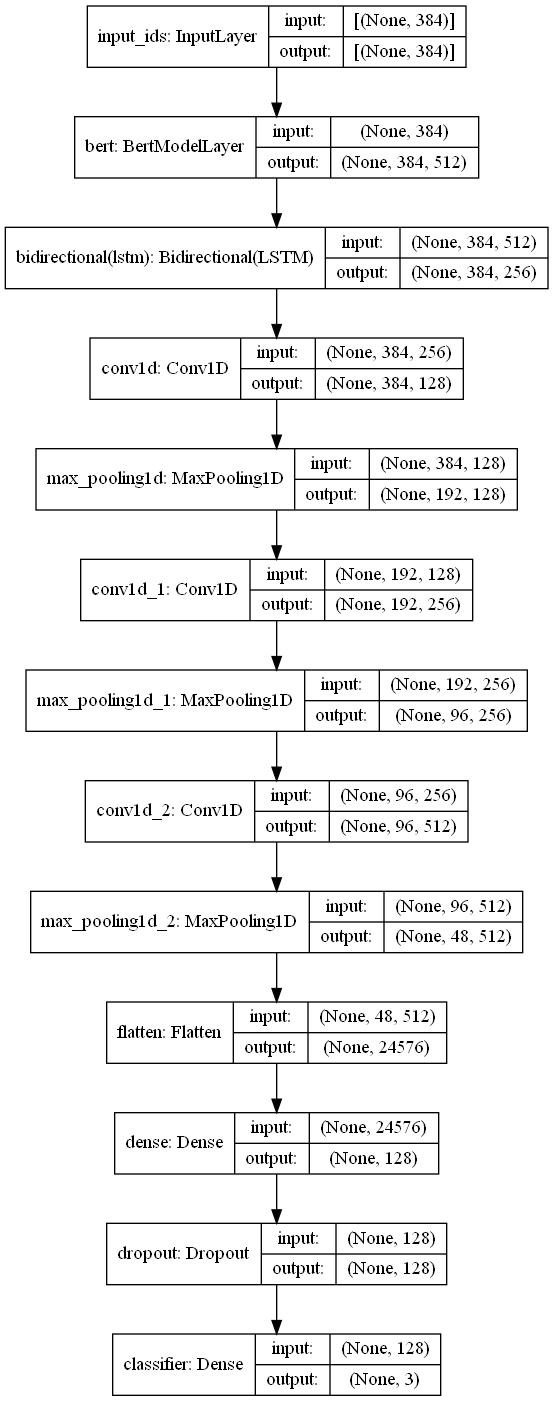

In [20]:
# Plot architecture model
tf.keras.utils.plot_model(model, show_shapes=True, dpi=96,to_file=figs_dir+'LSTM+CNN-model.jpeg') #to_file='model.jpeg'

## Model training

In [21]:
# Save model
model_ckpt_path = f"[{bert_model_name}]{model_name}_V{model_ver}_{max_seq_len}.hdf5"
checkpoint = ModelCheckpoint(mod_dir+model_ckpt_path, monitor='val_sparse_categorical_accuracy', mode='max',verbose=1, save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint]

# Training
print(f"Training model with {bert_model_name}_{model_name}_V{model_ver}_{max_seq_len}\n")
train_history = model.fit(data.train_x, data.train_y, validation_data=(data.val_x,data.val_y), epochs=3, batch_size=12, verbose=1, callbacks=callbacks_list)

Training model with uncased_L-4_H-512_A-8_LSTM+CNN_V0_384

Epoch 1/3


C:\Users\Hind\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


681/681 [==============================] - 225s 316ms/step - loss: 0.4726 - sparse_categorical_accuracy: 0.8332 - val_loss: 0.3112 - val_sparse_categorical_accuracy: 0.8767

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.87665, saving model to C:\Users\Hind\Desktop\GitHub code/Models\[uncased_L-4_H-512_A-8]LSTM+CNN_V0_384.hdf5
Epoch 2/3
681/681 [==============================] - 207s 304ms/step - loss: 0.3242 - sparse_categorical_accuracy: 0.8687 - val_loss: 0.2784 - val_sparse_categorical_accuracy: 0.8899

Epoch 00002: val_sparse_categorical_accuracy improved from 0.87665 to 0.88987, saving model to C:\Users\Hind\Desktop\GitHub code/Models\[uncased_L-4_H-512_A-8]LSTM+CNN_V0_384.hdf5
Epoch 3/3
681/681 [==============================] - 213s 312ms/step - loss: 0.2608 - sparse_categorical_accuracy: 0.8933 - val_loss: 0.2747 - val_sparse_categorical_accuracy: 0.8954

Epoch 00003: val_sparse_categorical_accuracy improved from 0.88987 to 0.89537, saving model to C:\Use

In [ ]:
# Plot accuracy and loss
history_dict = train_history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# Save architecture model
config = model.to_json()
model_config_path = f"[{bert_model_name}]{model_name}_V{model_ver}_{max_seq_len}.json"
with open(mod_dir+model_config_path, "w") as outfile:
    json.dump(config, outfile)

## Evaluate

In [ ]:
model.load_weights(mod_dir+model_ckpt_path)
y_pred_proba = model.predict(data.test_x)
get_metrics(data.test_y, y_pred_proba)